In [1]:
##################################################
# Triple Exponential Smoothing (Holt-Winters)
##################################################

<center><img src="https://github.com/Metin323/.png/blob/e7fbb402c98d0010ea9a92853350f3f55959c721/333.png?raw=true" style="width:100%;height:50%;"></center>

In [2]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
import seaborn as sns
sns.set_style("darkgrid") 

warnings.filterwarnings('ignore')

############################
## Veri Seti
############################

### Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.
### Period of Record: March 1958 - December 2001

In [3]:
data = sm.datasets.co2.load_pandas()

In [4]:
y = data.data

## EDA

In [5]:
y.head(20)

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
1958-05-03,316.9
1958-05-10,NaN
1958-05-17,317.5
1958-05-24,317.9
1958-05-31,NaN


In [6]:
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Freq: W-SAT
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     2225 non-null   float64
dtypes: float64(1)
memory usage: 35.7 KB


In [7]:
y_mn = y['co2'].resample('MS').mean()

In [8]:
y_mn.head(20)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
1958-08-01    314.950000
1958-09-01    313.500000
1958-10-01           NaN
1958-11-01    313.425000
1958-12-01    314.700000
1959-01-01    315.500000
1959-02-01    316.700000
1959-03-01    316.733333
1959-04-01    317.675000
1959-05-01    318.325000
1959-06-01    318.025000
1959-07-01    316.525000
1959-08-01    314.900000
1959-09-01    313.825000
1959-10-01    313.400000
Freq: MS, Name: co2, dtype: float64

In [9]:
y.isnull().sum()

co2    59
dtype: int64

In [10]:
y_mn.isnull().sum()

5

### Nan değerden önce ve sonra gelen iki değerin orta noktasını kullanarak Nan değeri doldurduk.

In [11]:
y_mn.interpolate(method='linear', inplace=True)

In [12]:
y_mn.head(20)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    316.529167
1958-07-01    315.625000
1958-08-01    314.950000
1958-09-01    313.500000
1958-10-01    313.462500
1958-11-01    313.425000
1958-12-01    314.700000
1959-01-01    315.500000
1959-02-01    316.700000
1959-03-01    316.733333
1959-04-01    317.675000
1959-05-01    318.325000
1959-06-01    318.025000
1959-07-01    316.525000
1959-08-01    314.900000
1959-09-01    313.825000
1959-10-01    313.400000
Freq: MS, Name: co2, dtype: float64

In [13]:
len(y_mn)

526

<Axes: >

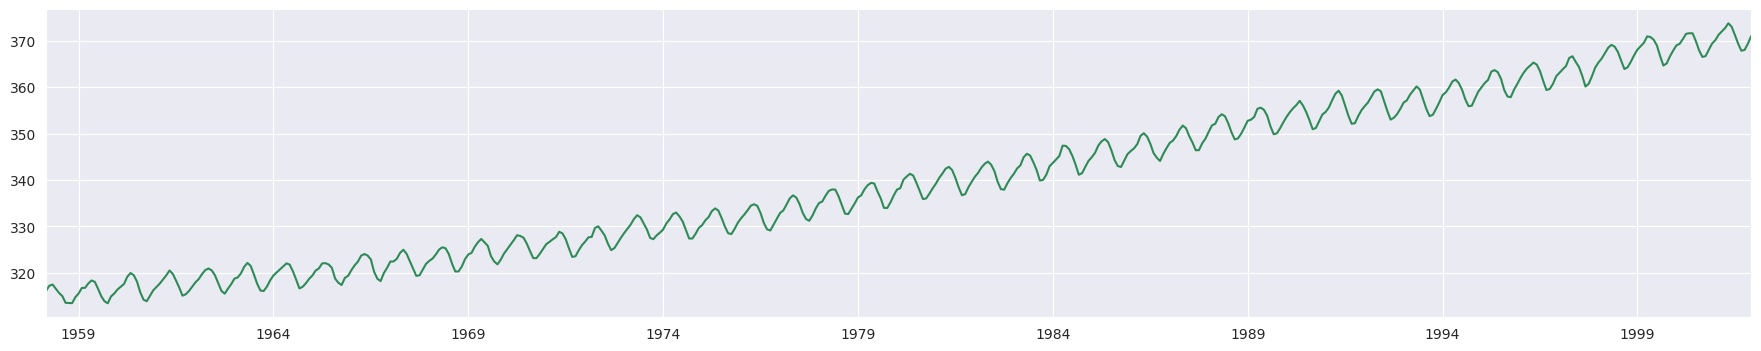

In [14]:
y_mn.plot(figsize=(22, 4), color='seagreen')

## Test ve Train set oluşturma 

In [15]:
############################
# Holdout
############################

train = y_mn[:'1997-12-01']
len(train)  # 478 ay

478

In [16]:
# 1998'ilk ayından 2001'in sonuna kadar test set.
test = y_mn['1998-01-01':]
len(test)  # 48 ay

48

## Durağanlık Testi (Dickey-Fuller Testi)

In [17]:
def is_stationary(y_mn):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(y_mn)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

In [18]:
is_stationary(y_mn)

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


In [19]:
# Zaman Serisi Bileşenleri ve Durağanlık Testi

def ts_decompose(y_mn, model="additive", stationary=False):
    result = seasonal_decompose(y_mn, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(22)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y_mn, 'k', label='Original ' + model,color='seagreen')
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend',color='seagreen')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)),color='seagreen')
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)),color='seagreen')
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y_mn)

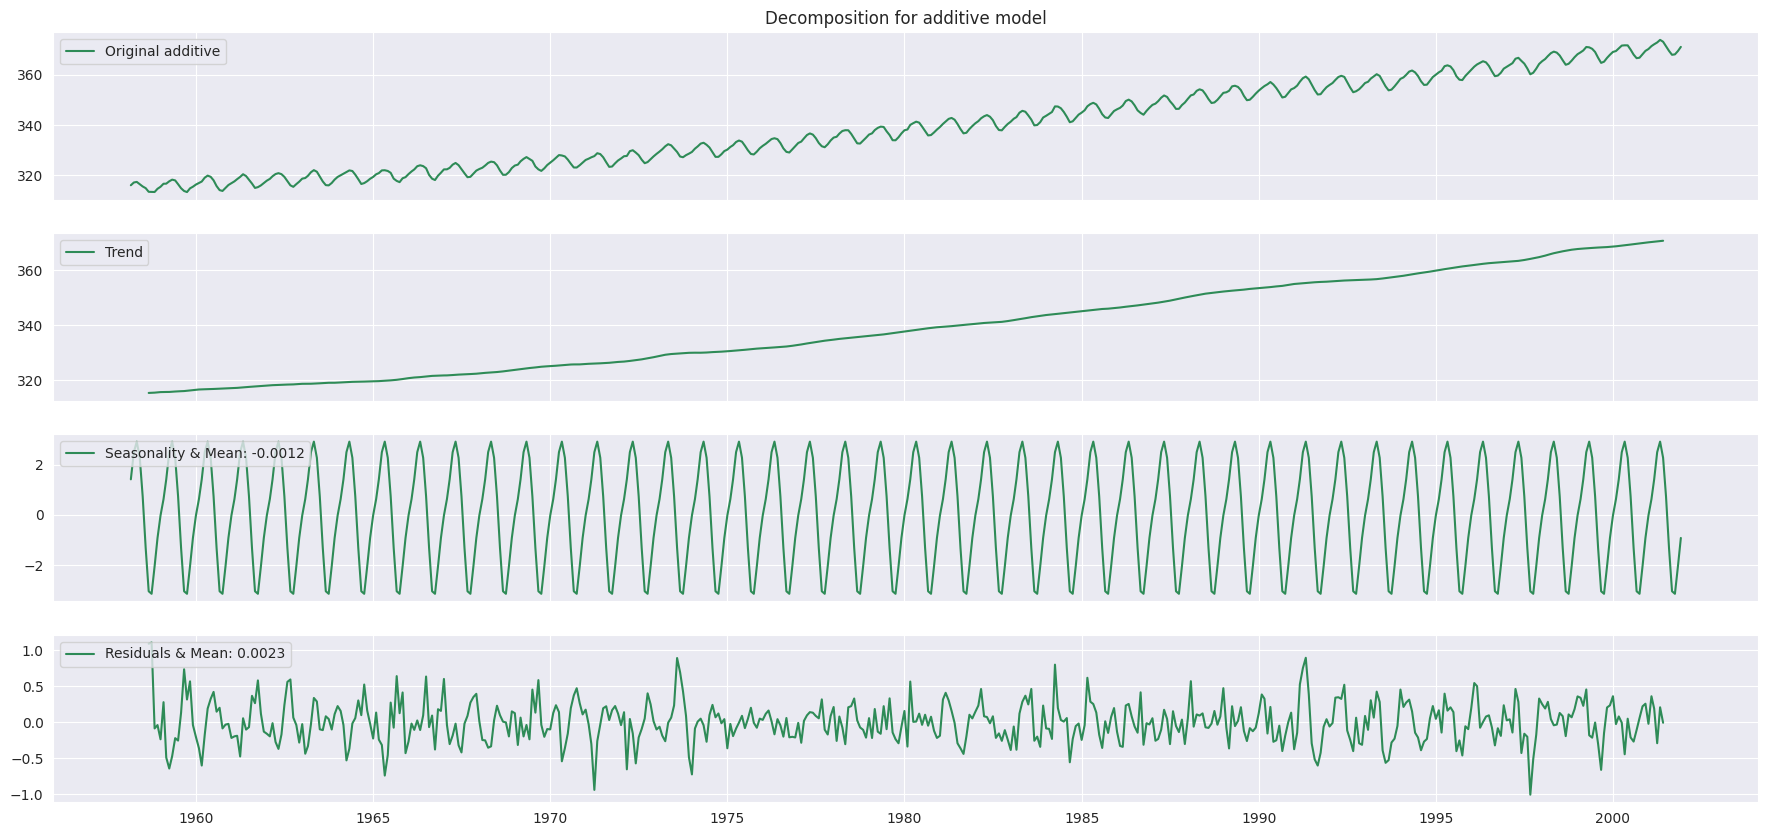

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


In [20]:
ts_decompose(y_mn, stationary=True)

## Model Kurulumu

In [21]:
tes_model = ExponentialSmoothing(train,
                                 trend="add",
                                 seasonal="add",
                                 seasonal_periods=12).fit(smoothing_level=0.5,
                                                          smoothing_slope=0.5,
                                                          smoothing_seasonal=0.5)

In [22]:
y_pred = tes_model.forecast(48)

## Sonuçların İncelenmesi

In [23]:
def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    
    plt.figure(figsize=(22, 4))
    
    train["1985":].plot(legend=True, label="TRAIN", color='seagreen', title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", color='aquamarine')
    y_pred.plot(legend=True, label="PREDICTION", color='red', linewidth=3)
    
    plt.show()

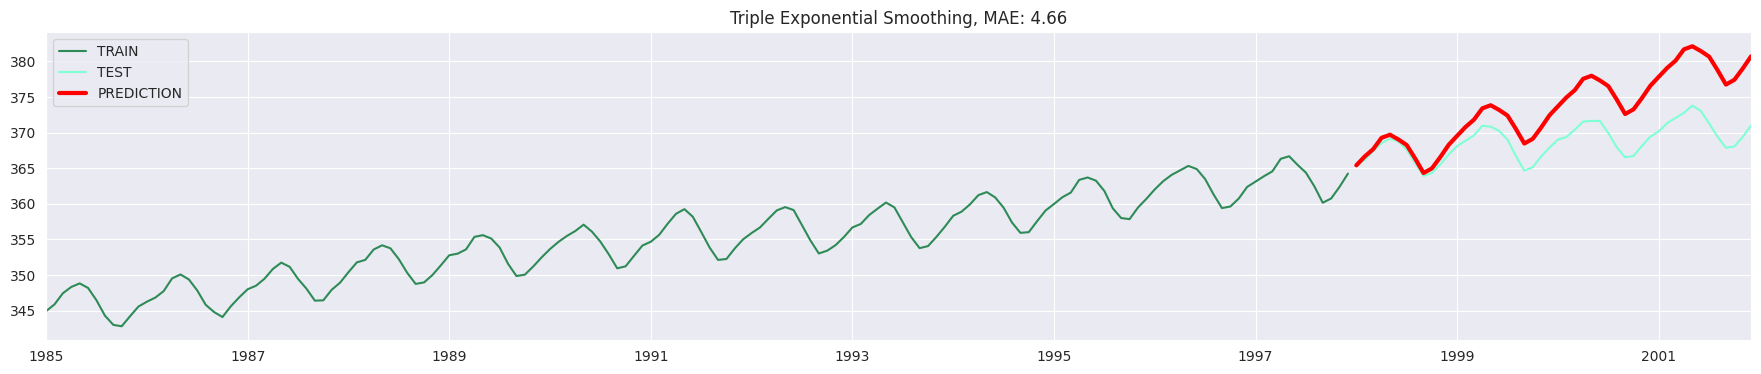

In [24]:
plot_co2(train, test, y_pred, "Triple Exponential Smoothing")

## Hyperparameter Optimization

In [25]:
alphas = betas = gammas = np.arange(0.20, 1, 0.10)

abg = list(itertools.product(alphas, betas, gammas))

In [26]:
def tes_optimizer(train, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

In [27]:
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg)

[0.2, 0.2, 0.2, 0.88]
[0.2, 0.2, 0.3, 0.79]
[0.2, 0.2, 0.4, 0.76]
[0.2, 0.2, 0.5, 0.75]
[0.2, 0.2, 0.6, 0.72]
[0.2, 0.2, 0.7, 0.67]
[0.2, 0.2, 0.8, 0.67]
[0.2, 0.2, 0.9, 0.71]
[0.2, 0.3, 0.2, 0.86]
[0.2, 0.3, 0.3, 0.93]
[0.2, 0.3, 0.4, 0.94]
[0.2, 0.3, 0.5, 0.95]
[0.2, 0.3, 0.6, 1.09]
[0.2, 0.3, 0.7, 1.43]
[0.2, 0.3, 0.8, 1.95]
[0.2, 0.3, 0.9, 1.78]
[0.2, 0.4, 0.2, 1.63]
[0.2, 0.4, 0.3, 1.74]
[0.2, 0.4, 0.4, 1.64]
[0.2, 0.4, 0.5, 1.68]
[0.2, 0.4, 0.6, 2.3]
[0.2, 0.4, 0.7, 4.44]
[0.2, 0.4, 0.8, 11.11]
[0.2, 0.4, 0.9, 4.46]
[0.2, 0.5, 0.2, 2.46]
[0.2, 0.5, 0.3, 2.52]
[0.2, 0.5, 0.4, 1.94]
[0.2, 0.5, 0.5, 1.82]
[0.2, 0.5, 0.6, 1.86]
[0.2, 0.5, 0.7, 3.08]
[0.2, 0.5, 0.8, 4.67]
[0.2, 0.5, 0.9, 3.49]
[0.2, 0.6, 0.2, 3.37]
[0.2, 0.6, 0.3, 3.11]
[0.2, 0.6, 0.4, 0.71]
[0.2, 0.6, 0.5, 0.64]
[0.2, 0.6, 0.6, 1.76]
[0.2, 0.6, 0.7, 2.67]
[0.2, 0.6, 0.8, 4749.19]
[0.2, 0.6, 0.9, 456.27]
[0.2, 0.7, 0.2, 4.71]
[0.2, 0.7, 0.3, 4.56]
[0.2, 0.7, 0.4, 7.55]
[0.2, 0.7, 0.5, 0.64]
[0.2, 0.7, 0.6, 2.15]
[0.2,

## Final Model

In [28]:
final_tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_trend=best_beta, smoothing_seasonal=best_gamma)


In [29]:
y_pred = final_tes_model.forecast(48)

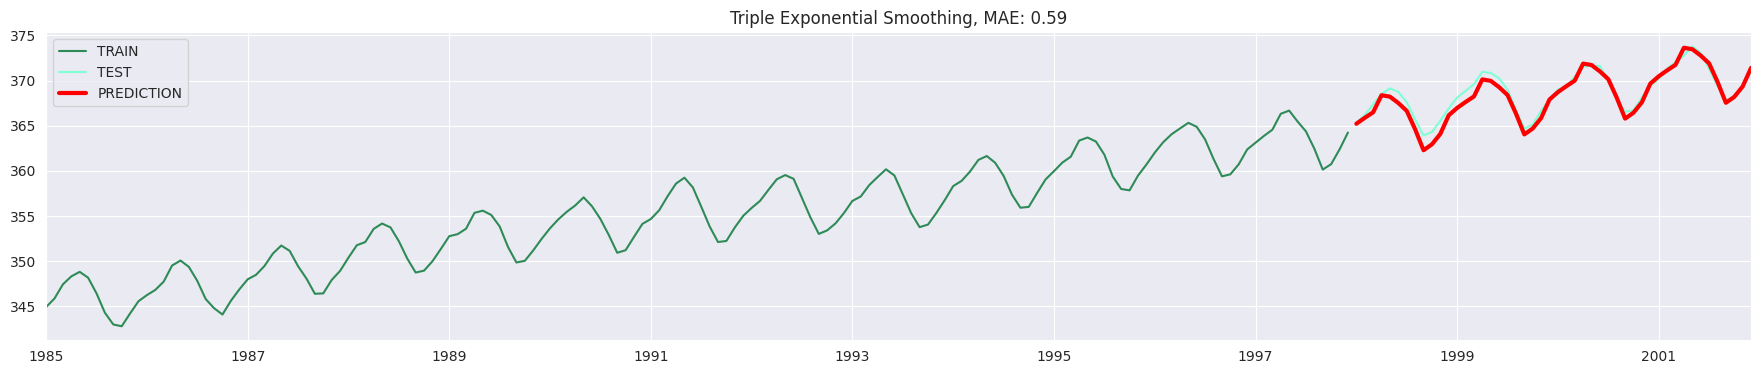

In [30]:
plot_co2(train, test, y_pred, "Triple Exponential Smoothing")